## Import Libraries

In [36]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from scipy.spatial.distance import cosine


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np


from PIL import Image, ImageEnhance

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## Load Data

In [37]:
data = np.load("/kaggle/input/marsfstu/mars_for_students.npz")
y_test_generated = np.load("/kaggle/input/marsfstu1/y_test_generated.npy")
print("y_test_generated shape:", y_test_generated.shape)

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

y_test_generated shape: (10022, 64, 128)
Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


## Inspect Data

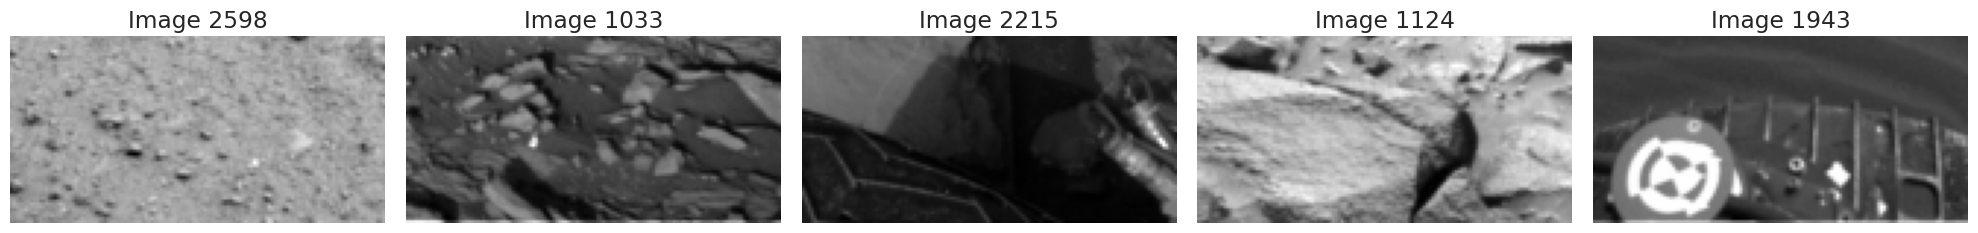

In [38]:
# Plot the randomly selected images
num_samples = 5
random_indices = np.random.choice(len(X_train), num_samples, replace=False)

fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i, ax in enumerate(axes):
    index = random_indices[i]
    ax.imshow(X_test[index], cmap='gray')  # Display the image in grayscale
    ax.axis('off')  # Hide axis
    ax.set_title(f"Image {index}")

plt.tight_layout()
plt.show()

### Manual selection of noise images


In [39]:
noise_indices = [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, \
                536, 552, 669, 675, 741, 744, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, \
                1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, \
                1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, \
                1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, \
                2365, 2372, 2414, 2453, 2522, 2535]

print(f"Found {len(noise_indices)} contamination images")

Found 106 contamination images


### Split data into cleaned data and noise

In [40]:
def split_data(X, y, noise_indices):
    # Convert noise_indices to a set for faster lookup
    noise_indices_set = set(noise_indices)

    # Split into cleaned and contamination based on noise_indices
    contamination_X = X[noise_indices]
    contamination_y = y[noise_indices]
    
    # Get all indices that are not in noise_indices (cleaned data)
    cleaned_indices = [i for i in range(len(X)) if i not in noise_indices_set]

    # Cleaned data
    cleaned_X = X[cleaned_indices]
    cleaned_y = y[cleaned_indices]

    return cleaned_X, cleaned_y, contamination_X, contamination_y

cleaned_X, cleaned_y, contamination_X, contamination_y = split_data(X_train, y_train, noise_indices)

# To check the results
print(f"Cleaned data shape: {cleaned_X.shape}")
print(f"Contamination data shape: {contamination_X.shape}")


Cleaned data shape: (2509, 64, 128)
Contamination data shape: (106, 64, 128)


### Inspect a slice of cleaned data

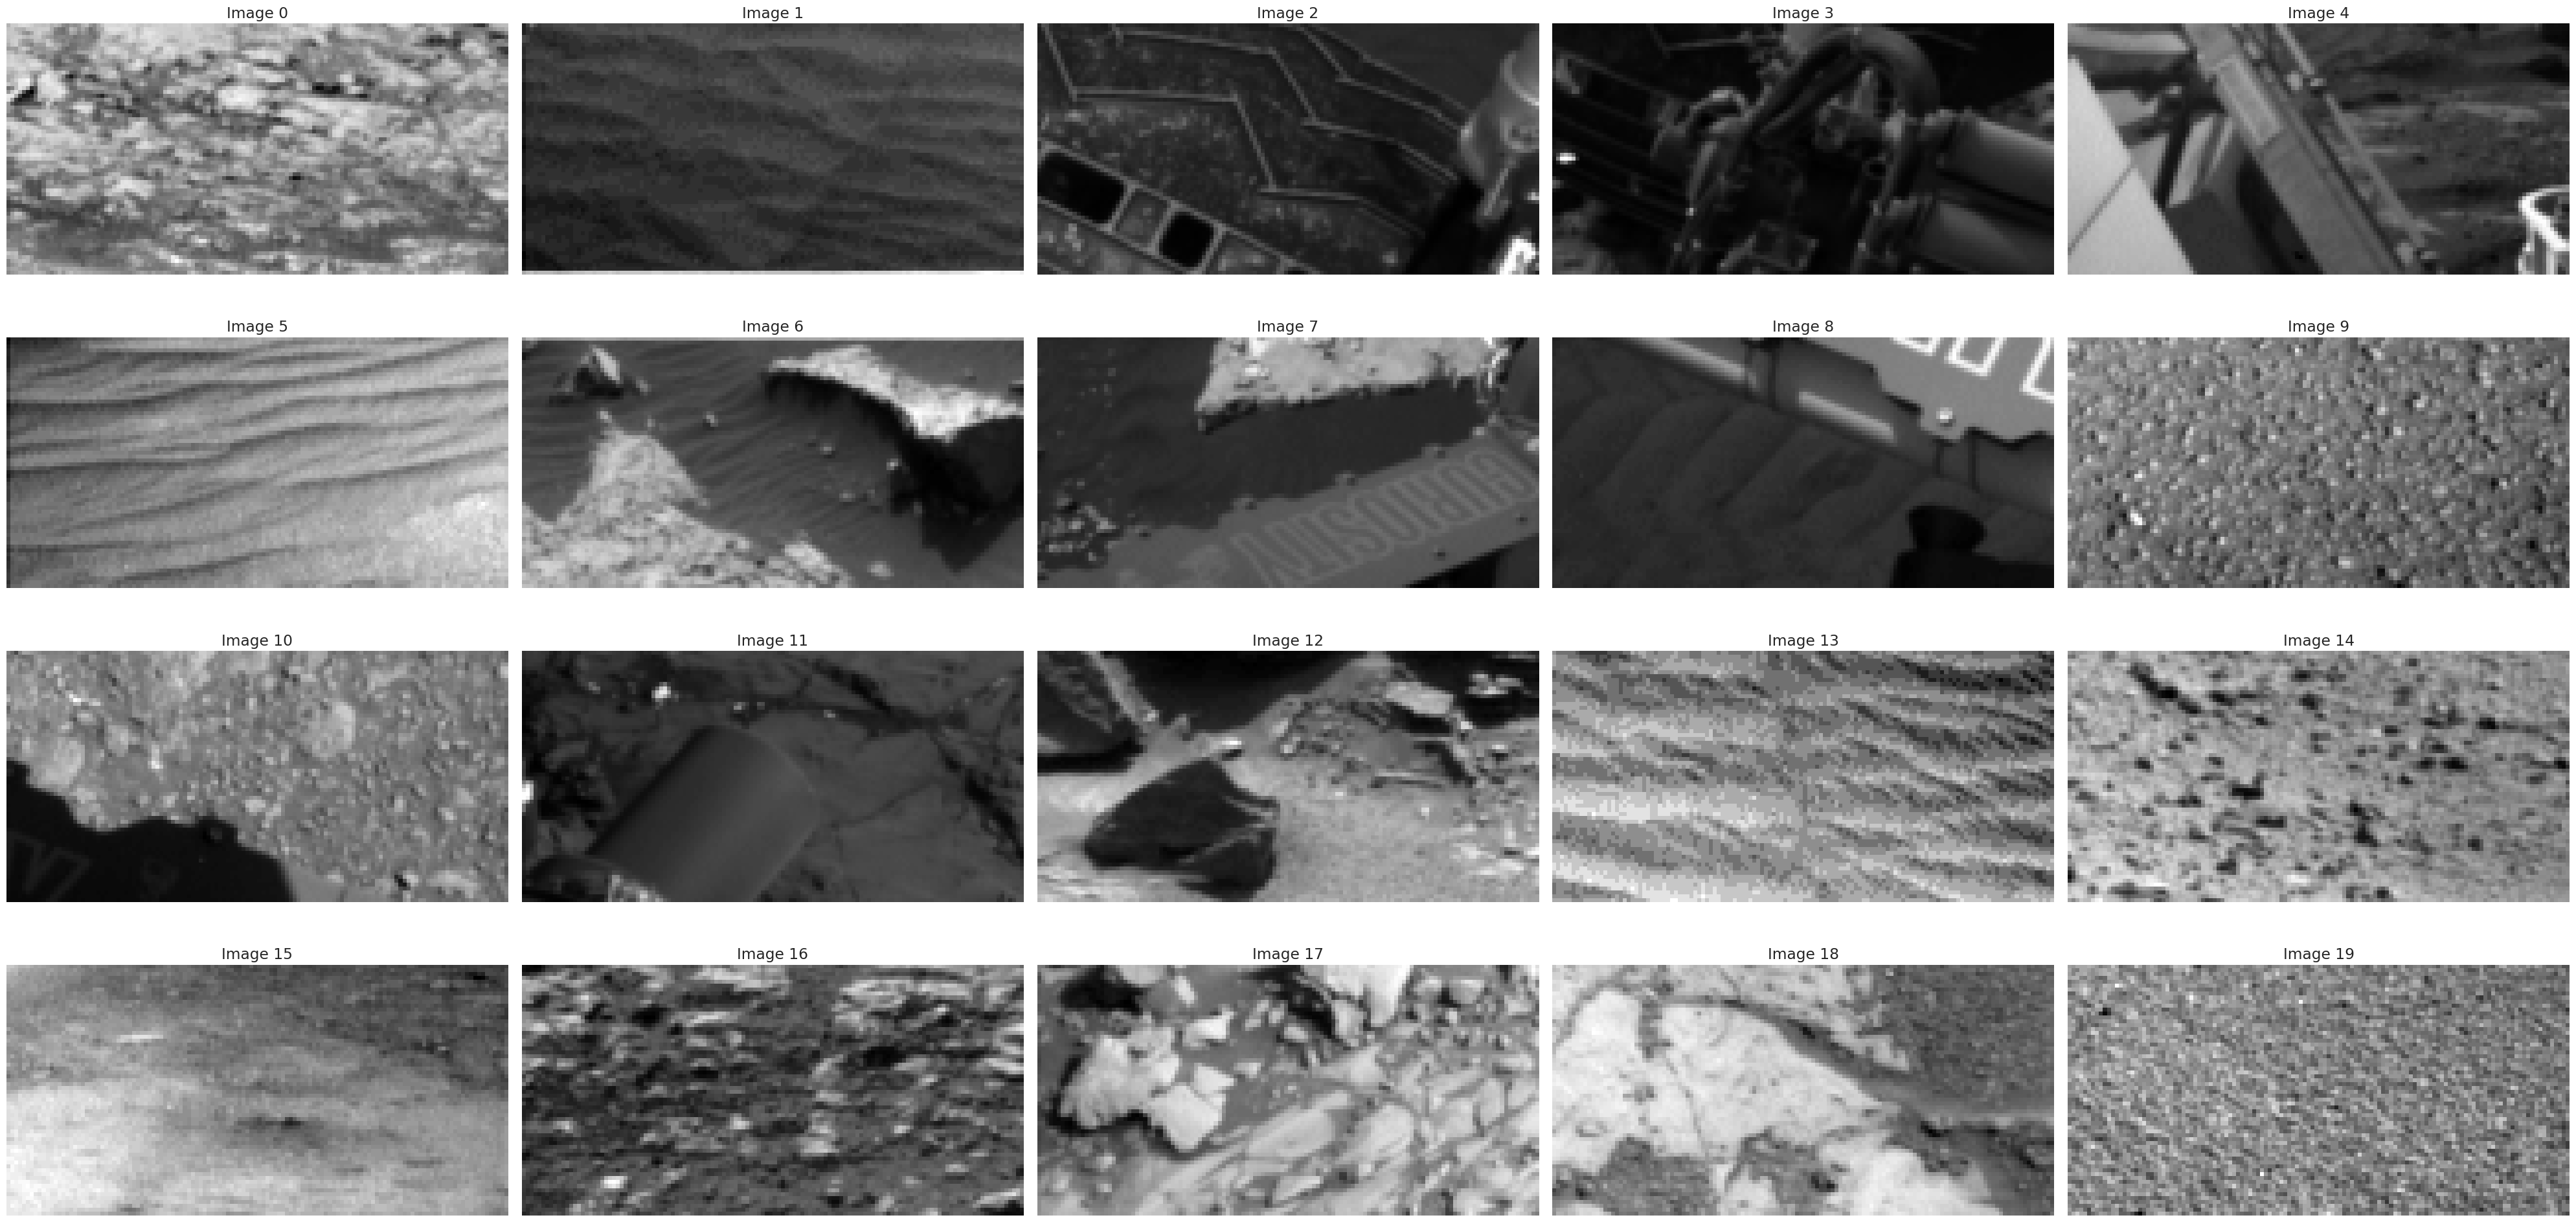

In [41]:
# Parameters for layout
X_train_cleaned_selected = cleaned_X[:20]
images_per_row = 5  # Number of images per row
num_images = len(X_train_cleaned_selected)  # Total number of images
num_rows = math.ceil(num_images / images_per_row)  # Calculate the number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(40, 5 * num_rows))

# Flatten the axes for easier iteration (handles cases where `axes` is 2D)
axes = axes.ravel()

# Plot all the contamination images
for i, ax in enumerate(axes):
    if i < num_images:
        ax.imshow(X_train_cleaned_selected[i], cmap='gray')  # Display the image in grayscale
        ax.axis('off')  # Hide axis
        ax.set_title(f"Image {i}")
    else:
        ax.axis('off')  # Hide any unused subplot axes

plt.tight_layout()
plt.show()

### Inspect all of the noise images

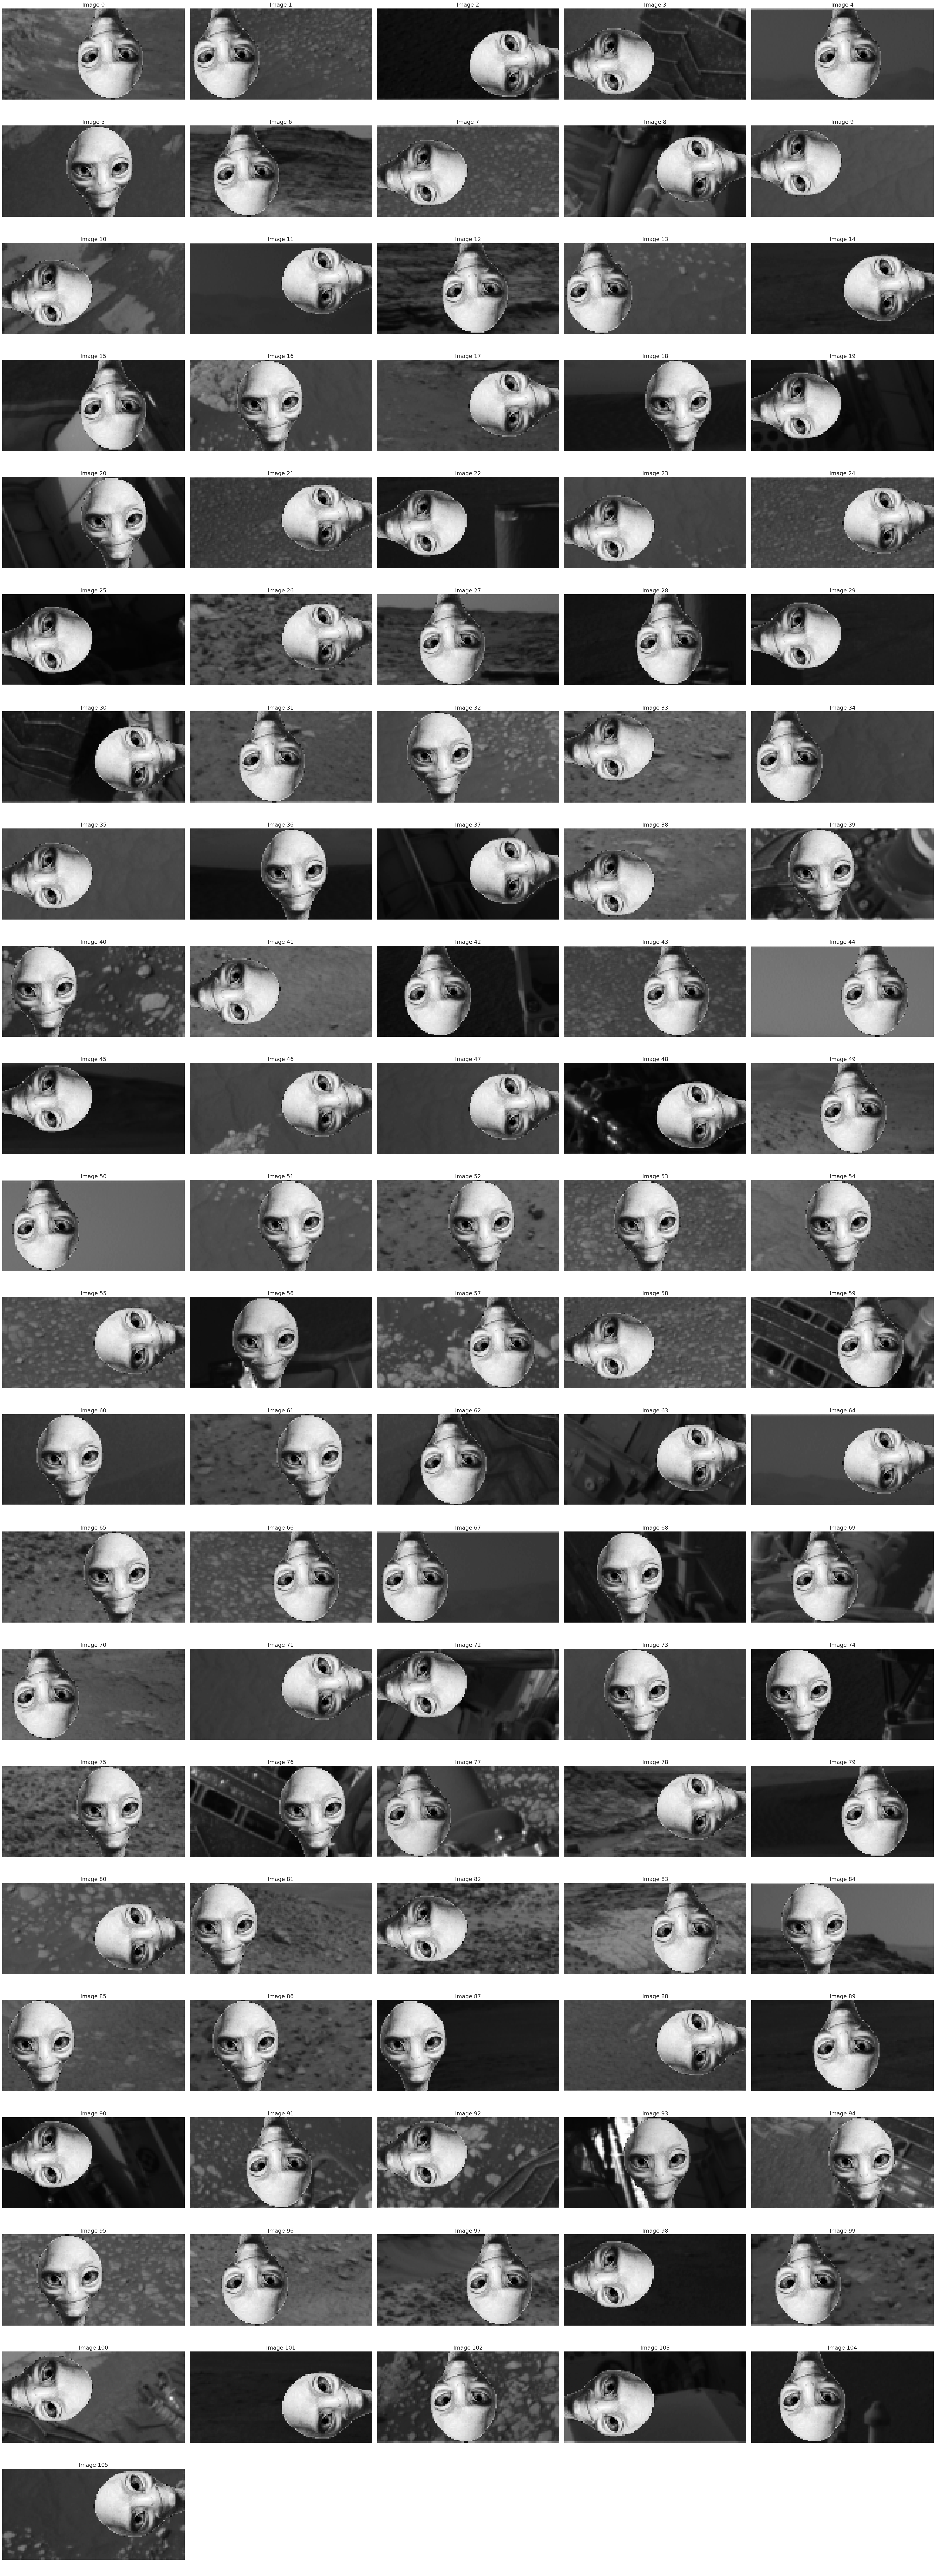

In [42]:
# Parameters for layout
images_per_row = 5  # Number of images per row
num_images = len(contamination_X)  # Total number of images
num_rows = math.ceil(num_images / images_per_row)  # Calculate the number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(40, 5 * num_rows))

# Flatten the axes for easier iteration (handles cases where `axes` is 2D)
axes = axes.ravel()

# Plot all the contamination images
for i, ax in enumerate(axes):
    if i < num_images:
        ax.imshow(contamination_X[i], cmap='gray')  # Display the image in grayscale
        ax.axis('off')  # Hide axis
        ax.set_title(f"Image {i}")
    else:
        ax.axis('off')  # Hide any unused subplot axes

plt.tight_layout()
plt.show()

### Looking at cleaned data

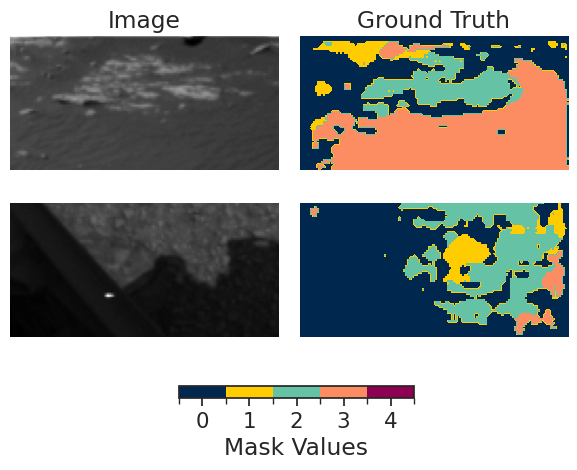

In [43]:
# Define the unique classes in the mask
classes = [0, 1, 2, 3, 4]  # Replace with the actual values in cleaned_y

# Define a custom colormap using the new colors
cmap = mcolors.ListedColormap(["#00274d", "#ffcc00", "#66c2a5", "#fc8d62", "#8e0152"])
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(classes) + 1) - 0.5, ncolors=len(classes))

plt.figure(figsize=(6, 4))

random_index1 = 1609
random_index2 = 2005

# Plot first image
plt.subplot(2, 2, 1)
plt.imshow(X_test[random_index1], cmap="gray")
plt.axis("off")
plt.title("Image")

plt.subplot(2, 2, 2)
im = plt.imshow(y_test_generated[random_index1], cmap=cmap, norm=norm)
plt.title("Ground Truth")
plt.axis("off")

# Plot second image
plt.subplot(2, 2, 3)
plt.imshow(X_test[random_index2], cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(y_test_generated[random_index2], cmap=cmap, norm=norm)
plt.axis("off")

# Adjust layout to make room for the colorbar
plt.subplots_adjust(bottom=-0.1)  # Adjust to move colorbar lower

# Add colorbar with smaller size
cbar = plt.colorbar(im, ax=plt.gcf().axes, orientation='horizontal', fraction=0.03, pad=0.1)
cbar.set_ticks(classes)
cbar.set_label("Mask Values")

# Display the images
plt.tight_layout()
plt.show()


### Define Model Parameters

In [44]:
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4,  # big rock
}

# Set batch size for training
BATCH_SIZE = 16

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 100

# Set maximum number of training epochs
EPOCHS = 500

NUM_CLASSES = len(set(category_map.values()))
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 5


### Split into training and validation

In [45]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(
    cleaned_X, cleaned_y, test_size=0.2, random_state=42
)

# Print the shapes to confirm the split
print(f"Training set: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Validation set: X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


Training set: X_train shape: (2007, 64, 128), y_train shape: (2007, 64, 128)
Validation set: X_val shape: (502, 64, 128), y_val shape: (502, 64, 128)


In [46]:
# Normalize the data to [0, 1]
X_train = X_train/ 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Check if the data already has the channel dimension (i.e., check if the shape has 4 dimensions)
if X_train.ndim == 3:  # (batch_size, height, width)
    # Add the channel dimension if missing
    X_train = np.expand_dims(X_train, axis=-1)  # Adds the channel dimension
    X_val = np.expand_dims(X_val, axis=-1)  # Same for validation data
    X_test = np.expand_dims(X_test, axis=-1)

# Check the shapes to make sure they are correct
print(f"X_train shape: {X_train.shape}")  # Should be (batch_size, 64, 128, 1)
print(f"X_val shape: {X_val.shape}")  # Same for validation
print(f"X_val shape: {X_test.shape}")  # Same for validation


X_train shape: (2007, 64, 128, 1)
X_val shape: (502, 64, 128, 1)
X_val shape: (10022, 64, 128, 1)


In [47]:
X_train = np.concatenate([X_train, X_test[:2000]], axis=0)
y_train = np.concatenate([y_train, y_test_generated[:2000]], axis=0)

print(f"X_train shape: {X_train.shape}") 
print(f"X_train shape: {y_train.shape}") 

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

# Check the shape of the dataset to ensure it's batched correctly
for images, labels in train_dataset.take(1):
    print(f"Batch shape: {images.shape}")  # Should be (batch_size, 64, 128, 1)


X_train shape: (4007, 64, 128, 1)
X_train shape: (4007, 64, 128)
Batch shape: (32, 64, 128, 1)


In [48]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
        
    flip_prob = tf.random.uniform([], seed=seed)
    if flip_prob > 0.5:
        image = tf.image.flip_up_down(image)
        label = tf.image.flip_left_right(label)
    else:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_up_down(label)
    return image, label

def augmentation(image, label, seed=None):
    # Use preprocessing layers for data augmentation
    return random_flip(image, label, seed)

In [49]:
train_dataset2 = train_dataset.map(augmentation)
train_dataset_aug = train_dataset.concatenate(train_dataset2)
for images, labels in train_dataset.take(1):
    print(f"Batch shape: {images.shape}")  # Should be (batch_size, 64, 128, 1)

Batch shape: (32, 64, 128, 1)


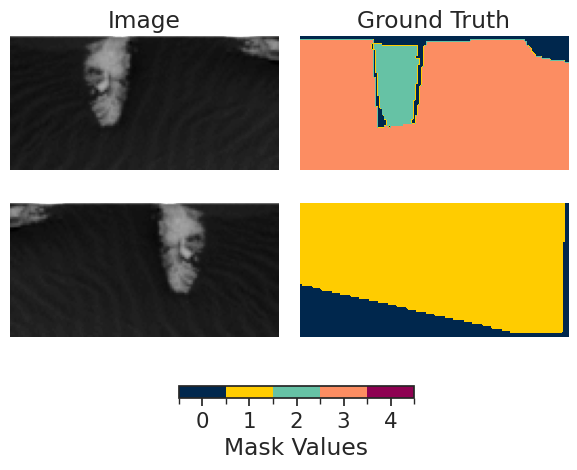

In [51]:
# Define the unique classes in the mask
classes = [0, 1, 2, 3, 4]  # Replace with the actual values in y_train

# Define a custom colormap using the new colors
cmap = mcolors.ListedColormap(["#00274d", "#ffcc00", "#66c2a5", "#fc8d62", "#8e0152"])
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(classes) + 1) - 0.5, ncolors=len(classes))

plt.figure(figsize=(6, 4))

index = 1

# Get one batch from the dataset
for image_batch, label_batch in train_dataset.take(1):  # Take a single batch
    # Convert tensors to numpy arrays for plotting
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()

    # Plot first image and label
    plt.subplot(2, 2, 1)
    plt.imshow(image_batch[index], cmap="gray")
    plt.axis("off")
    plt.title("Image")

    plt.subplot(2, 2, 2)
    im = plt.imshow(label_batch[index], cmap=cmap, norm=norm)
    plt.title("Ground Truth")
    plt.axis("off")

for image_batch, label_batch in train_dataset2.take(1):  # Take a single batch
    # Convert tensors to numpy arrays for plotting
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()
    # Plot second image and label
    plt.subplot(2, 2, 3)
    plt.imshow(image_batch[index], cmap="gray")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(label_batch[index], cmap=cmap, norm=norm)
    plt.axis("off")

        # Adjust layout to make room for the colorbar
    plt.subplots_adjust(bottom=-0.1)  # Adjust to move colorbar lower

        # Add colorbar with smaller size
    cbar = plt.colorbar(im, ax=plt.gcf().axes, orientation='horizontal', fraction=0.03, pad=0.1)
    cbar.set_ticks(classes)
    cbar.set_label("Mask Values")

        # Display the images
    plt.tight_layout()
    plt.show()



## Models

In [52]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=64, IMG_WIDTH=128, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # inputs = augmentation(inputs)
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same',)(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(NUM_CLASSES, kernel_size=1, padding='same', activation="softmax", name='output_layer')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs], name='UNet')
    
    
    
    return model
 

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1     │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_18         │ (None, 64, 128, │       160 │ input_layer_1… │   Y   │
│ (Conv2D)          │ 16)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_9         │ (None, 64, 128, │         0 │ conv2d_18[0][… │   -   │
│ (Dropout)         │ 16)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_19         │ (None, 64, 128, │     2,320 │ dropout_9[0][… │   Y   │
│ (Conv2D)          │ 16)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_4   │ (None, 32, 64,  │         0 │ conv2d_19[0][… │   -   │
│ (MaxPooling2D)    │ 16)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_20         │ (None, 32, 64,  │     4,640 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_10        │ (None, 32, 64,  │         0 │ conv2d_20[0][… │   -   │
│ (Dropout)         │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_21         │ (None, 32, 64,  │     9,248 │ dropout_10[0]… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_5   │ (None, 16, 32,  │         0 │ conv2d_21[0][… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_22         │ (None, 16, 32,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_11        │ (None, 16, 32,  │         0 │ conv2d_22[0][… │   -   │
│ (Dropout)         │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_23         │ (None, 16, 32,  │    36,928 │ dropout_11[0]… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_6   │ (None, 8, 16,   │         0 │ conv2d_23[0][… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_24         │ (None, 8, 16,   │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_12        │ (None, 8, 16,   │         0 │ conv2d_24[0][… │   -   │
│ (Dropout)         │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_25         │ (None, 8, 16,   │   147,584 │ dropout_12[0]… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_7   │ (None, 4, 8,    │         0 │ conv2d_25[0][… │   - 

 Total params: 2,989,461 (11.40 MB)

 Trainable params: 2,989,461 (11.40 MB)

 Non-trainable params: 0 (0.00 B)

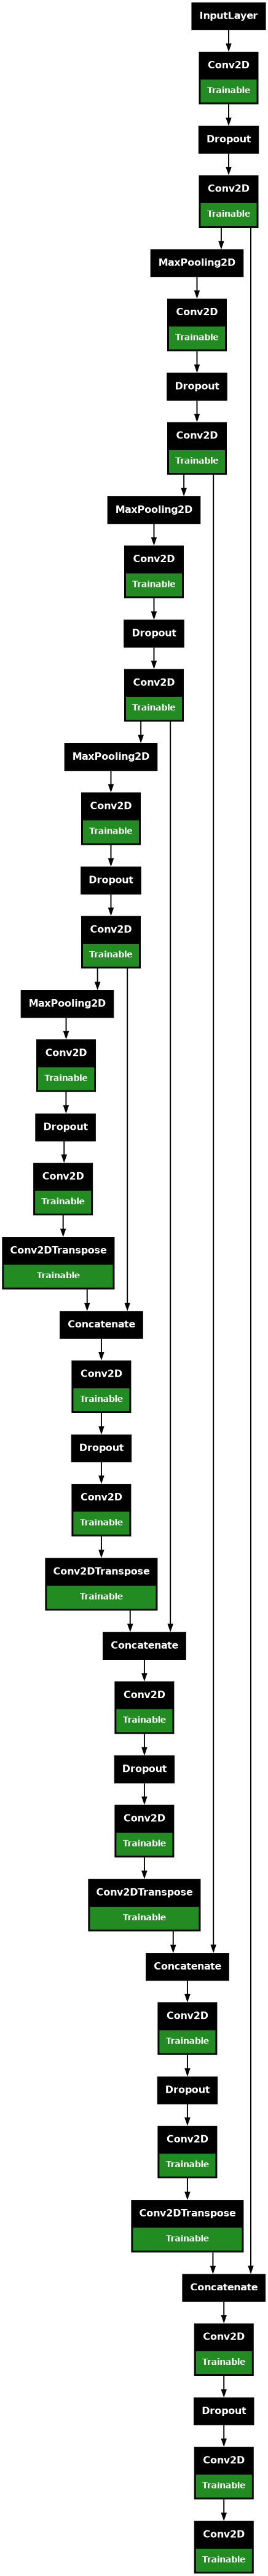

In [53]:
model = multi_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [54]:
def load_single_image(image_path, label_path, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)  # Ensure 3 channels
    image = tf.image.resize(image, input_size)   # Resize to fixed size
    image = tf.cast(image, tf.float32) / 255.0

    # Read and preprocess the label
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)  # Ensure single channel
    label = tf.image.resize(label, input_size, method='bilinear')  # Resize to fixed size
    label = tf.cast(label, tf.int32)

    return image, label

In [55]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, frequency=10):
        # Pass the full validation dataset and frequency for visualization
        self.val_dataset = val_dataset
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # Get one batch from the validation dataset
            for image_batch, label_batch in self.val_dataset.take(1):
                # Choose the first image in the batch for visualization
                image = image_batch[0].numpy()
                label = label_batch[0].numpy()

                # Add the batch dimension to image (model expects a batch of images)
                image = np.expand_dims(image, axis=0)  # Shape (1, 64, 128, 1)

                pred = self.model.predict(image, verbose=0)
                y_pred = tf.math.argmax(pred, axis=-1)
                y_pred = y_pred.numpy()

                # Create colormap
                num_classes = NUM_CLASSES
                # colormap = create_segmentation_colormap(num_classes)

                plt.figure(figsize=(16, 4))

                # Input image
                plt.subplot(1, 3, 1)
                plt.imshow(image.squeeze())
                plt.title("Input Image")
                plt.axis('off')
    
                # Ground truth
                plt.subplot(1, 3, 2)
                # colored_label = apply_colormap(label.squeeze(), colormap)
                plt.imshow(label.squeeze())
                plt.title("Ground Truth Mask")
                plt.axis('off')
    
                # Prediction
                plt.subplot(1, 3, 3)
                # colored_pred = apply_colormap(y_pred.squeeze(), colormap)
                plt.imshow(y_pred.squeeze())
                plt.title("Predicted Mask")
                plt.axis('off')
    
                plt.tight_layout()
                plt.show()
                plt.close()

                plt.show()


In [ ]:
#model = tfk.models.load_model("/kaggle/input/ganmodel/other/default/1/UNet_best_GAN.keras", compile=False)

In [56]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [57]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

# viz_callback = VizCallback(X_val[0], y_val[0])
viz_callback = VizCallback(val_dataset, frequency=10)



Epoch 1/50


W0000 00:00:1734187713.554888     186 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


125/252 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.2719 - loss: 1.4904 - mean_iou: 0.0999

W0000 00:00:1734187733.491671     188 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.3010 - loss: 1.4441 - mean_iou: 0.0988

W0000 00:00:1734187757.920194     185 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734187760.560315     188 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


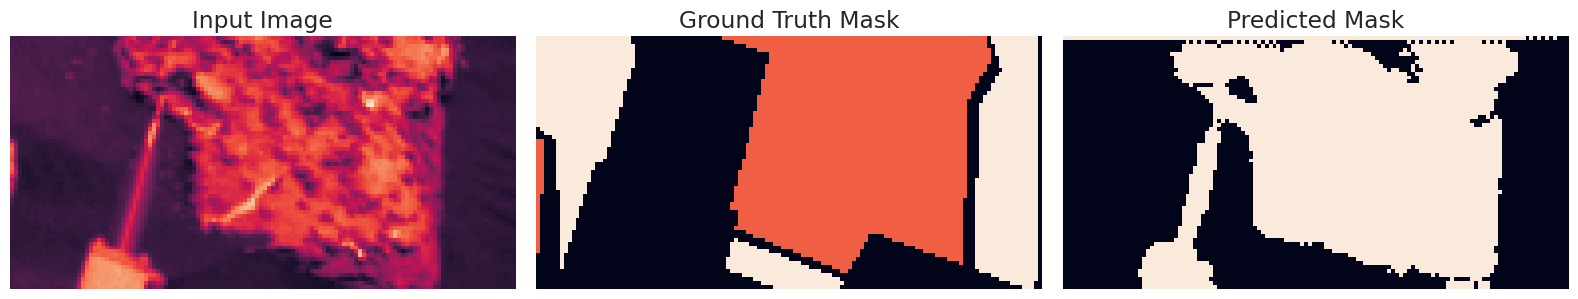

252/252 ━━━━━━━━━━━━━━━━━━━━ 59s 137ms/step - accuracy: 0.3013 - loss: 1.4436 - mean_iou: 0.0988 - val_accuracy: 0.3440 - val_loss: 1.3559 - val_mean_iou: 0.0776
Epoch 2/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.3655 - loss: 1.3416 - mean_iou: 0.0902 - val_accuracy: 0.3518 - val_loss: 1.3484 - val_mean_iou: 0.0812
Epoch 3/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.3741 - loss: 1.3288 - mean_iou: 0.0896 - val_accuracy: 0.3560 - val_loss: 1.3369 - val_mean_iou: 0.0826
Epoch 4/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.3888 - loss: 1.3092 - mean_iou: 0.0971 - val_accuracy: 0.3685 - val_loss: 1.3223 - val_mean_iou: 0.0887
Epoch 5/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.3994 - loss: 1.2837 - mean_iou: 0.1015 - val_accuracy: 0.3960 - val_loss: 1.2893 - val_mean_iou: 0.0932
Epoch 6/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.4337 - loss: 1.2357 - mean_iou: 0.1307 - val_accuracy: 0.4769 - val_loss: 1.2094 -

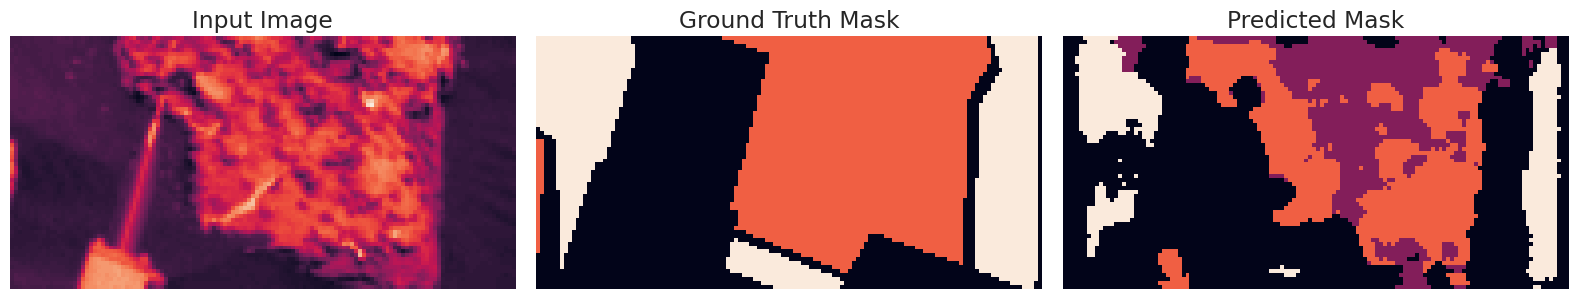

252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.6167 - loss: 0.9715 - mean_iou: 0.3241 - val_accuracy: 0.5711 - val_loss: 1.0677 - val_mean_iou: 0.2850
Epoch 12/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6290 - loss: 0.9524 - mean_iou: 0.3353 - val_accuracy: 0.5858 - val_loss: 1.0547 - val_mean_iou: 0.3006
Epoch 13/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6361 - loss: 0.9386 - mean_iou: 0.3416 - val_accuracy: 0.5927 - val_loss: 1.0480 - val_mean_iou: 0.3098
Epoch 14/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6393 - loss: 0.9318 - mean_iou: 0.3458 - val_accuracy: 0.5938 - val_loss: 1.0492 - val_mean_iou: 0.3077
Epoch 15/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6441 - loss: 0.9266 - mean_iou: 0.3496 - val_accuracy: 0.5996 - val_loss: 1.0418 - val_mean_iou: 0.3151
Epoch 16/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6517 - loss: 0.9143 - mean_iou: 0.3560 - val_accuracy: 0.5943 - val_loss: 1.04

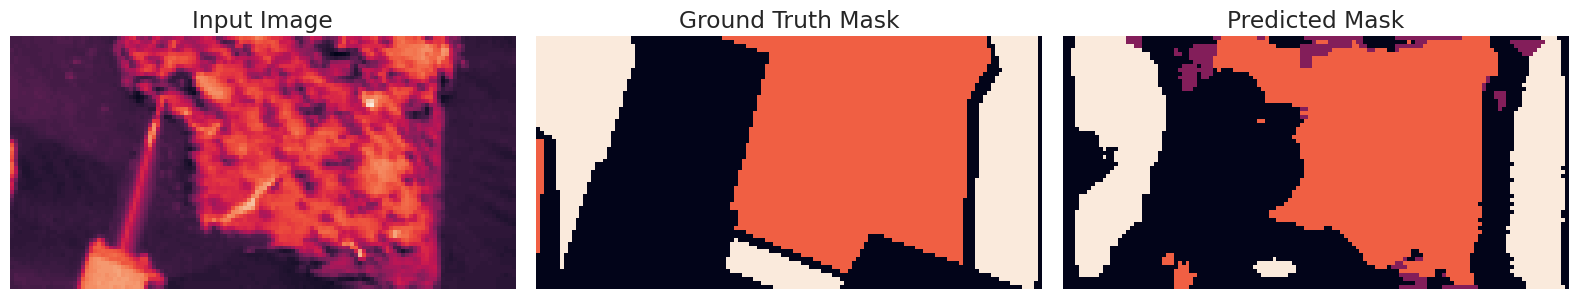

252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6672 - loss: 0.8886 - mean_iou: 0.3700 - val_accuracy: 0.6338 - val_loss: 1.0112 - val_mean_iou: 0.3483
Epoch 22/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6719 - loss: 0.8783 - mean_iou: 0.3727 - val_accuracy: 0.6441 - val_loss: 1.0184 - val_mean_iou: 0.3629
Epoch 23/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6717 - loss: 0.8826 - mean_iou: 0.3729 - val_accuracy: 0.6411 - val_loss: 1.0165 - val_mean_iou: 0.3623
Epoch 24/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6699 - loss: 0.8824 - mean_iou: 0.3727 - val_accuracy: 0.6544 - val_loss: 1.0089 - val_mean_iou: 0.3715
Epoch 25/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6797 - loss: 0.8678 - mean_iou: 0.3812 - val_accuracy: 0.6423 - val_loss: 1.0117 - val_mean_iou: 0.3612
Epoch 26/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6825 - loss: 0.8606 - mean_iou: 0.3833 - val_accuracy: 0.6476 - val_loss: 1.00

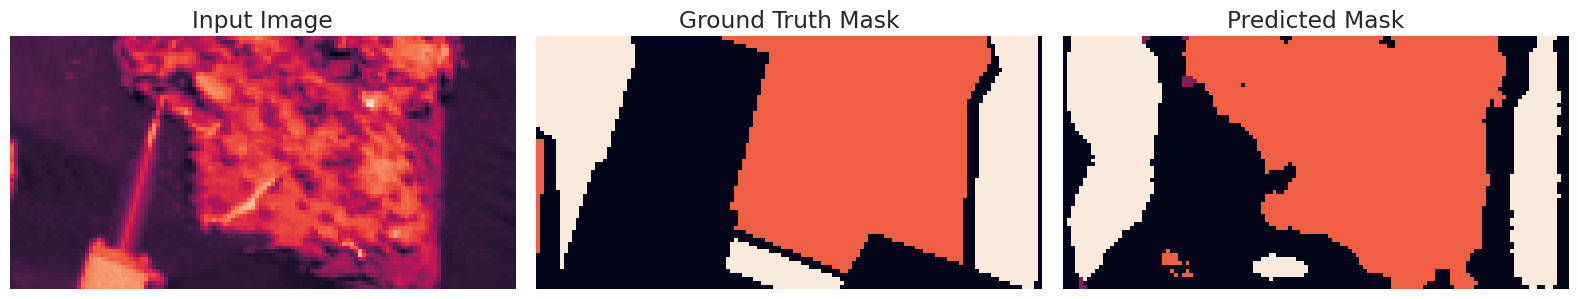

252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6909 - loss: 0.8407 - mean_iou: 0.3906 - val_accuracy: 0.6543 - val_loss: 0.9996 - val_mean_iou: 0.3716
Epoch 32/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6941 - loss: 0.8341 - mean_iou: 0.3923 - val_accuracy: 0.6588 - val_loss: 0.9927 - val_mean_iou: 0.3754
Epoch 33/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6974 - loss: 0.8273 - mean_iou: 0.3956 - val_accuracy: 0.6540 - val_loss: 0.9937 - val_mean_iou: 0.3719
Epoch 34/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6993 - loss: 0.8280 - mean_iou: 0.3971 - val_accuracy: 0.6627 - val_loss: 0.9845 - val_mean_iou: 0.3795
Epoch 35/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7026 - loss: 0.8203 - mean_iou: 0.4001 - val_accuracy: 0.6416 - val_loss: 0.9976 - val_mean_iou: 0.3616
Epoch 36/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7021 - loss: 0.8160 - mean_iou: 0.3990 - val_accuracy: 0.6437 - val_loss: 1.00

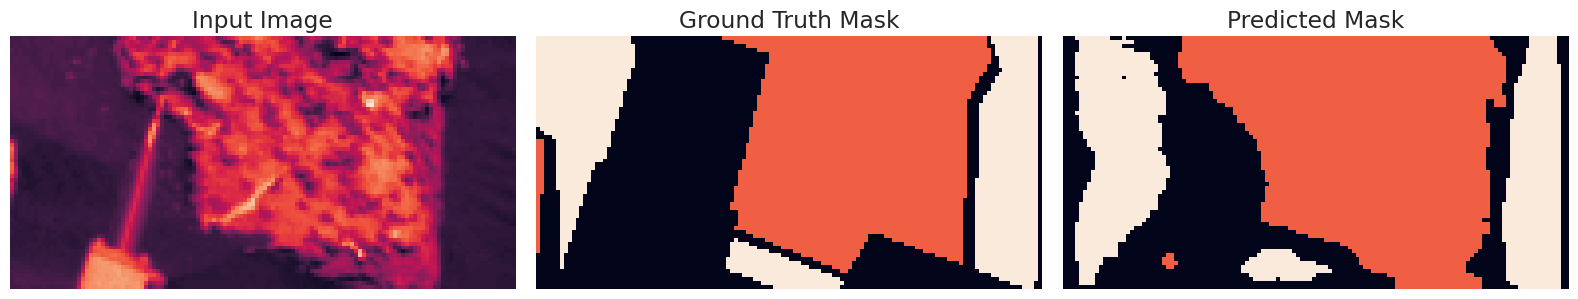

252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.7131 - loss: 0.7952 - mean_iou: 0.4047 - val_accuracy: 0.6613 - val_loss: 0.9753 - val_mean_iou: 0.3794
Epoch 42/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7147 - loss: 0.7873 - mean_iou: 0.4084 - val_accuracy: 0.6481 - val_loss: 0.9832 - val_mean_iou: 0.3675
Epoch 43/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7151 - loss: 0.7867 - mean_iou: 0.4081 - val_accuracy: 0.6601 - val_loss: 0.9666 - val_mean_iou: 0.3866
Epoch 44/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7205 - loss: 0.7744 - mean_iou: 0.4127 - val_accuracy: 0.6485 - val_loss: 0.9831 - val_mean_iou: 0.3655
Epoch 45/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7252 - loss: 0.7660 - mean_iou: 0.4157 - val_accuracy: 0.6599 - val_loss: 0.9597 - val_mean_iou: 0.3871
Epoch 46/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7164 - loss: 0.7778 - mean_iou: 0.4052 - val_accuracy: 0.6473 - val_loss: 0.96

In [58]:
# Train the model
history = model.fit(
    train_dataset_aug,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=1,
    shuffle = True
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

In [59]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('UNet_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [60]:
model = tfk.models.load_model(model_filename, compile=False)
# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print(f"Model loaded from {model_filename}")

Model loaded from UNet_38.71.keras


In [61]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Predictions shape: (10022, 64, 128)


In [62]:
import pandas as pd
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [63]:
# Create and download the csv submission file
timestep_str = model_filename.replace("UNet_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)